### The German Traffic Sign Benchmark

Student Name 1: Mihalis Gongolidis

Student Name 2: Alejandro González

Download full data set from http://benchmark.ini.rub.de/?section=gtsdb&subsection=dataset

In [6]:
!wget -c http://benchmark.ini.rub.de/Dataset_GTSDB/FullIJCNN2013.zip
!unzip FullIJCNN2013.zip

"wget" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.
"unzip" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [2]:
import numpy as np
import cv2

IMG_HEIGHT = 600
SIGN_SIZE = (224, 224)

# Function for reading the images
def readImages(rootpath, images_range, signs_range):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.
    Arguments: path to the traffic sign data, for example 'FullIJCNN2013'
    Returns:   list of images, list of corresponding labels'''
    images = {} # original image
    scales = {} # original scale
    for num in images_range:
        filename = rootpath + '/' + "{:05d}".format(num) + '.ppm'
        img = cv2.imread(filename, cv2.IMREAD_COLOR)
        scale = IMG_HEIGHT / float(img.shape[0])
        img_resized = cv2.resize(img, (int(img.shape[1]*scale),int(img.shape[0]*scale)))
        images.setdefault(filename,[]).append(img_resized)
        scales.setdefault(filename,[]).append(scale)

    files = [] # filenames
    signs = [] # traffic sign image
    bboxes = [] # corresponding box detection
    labels = [] # traffic sign type
    data = np.genfromtxt(rootpath + '/' + 'gt.txt', delimiter=';', dtype=str, usecols=range(0, 6))
    for elem in signs_range:
        filename = rootpath + '/' + data[elem][0]
        img = images.get(filename)[0]
        scale = scales.get(filename)[0]
        bbox = np.array([int(data[elem][1]), int(data[elem][2]), int(data[elem][3]), int(data[elem][4])]) * scale
        sign = img[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
        sign_resized = cv2.resize(sign, SIGN_SIZE)
        files.append(filename)
        signs.append(sign_resized)
        bboxes.append(bbox)
        labels.append(data[elem][5])
    return images, files, signs, bboxes, labels

In [3]:
# The German Traffic Sign Recognition Benchmark
train_images, train_files, train_signs, train_bboxes, train_labels = readImages('FullIJCNN2013', range(0,600), range(0,852))
test_images, test_files, test_signs, test_bboxes, test_labels = readImages('FullIJCNN2013', range(600,900), range(852,1213))

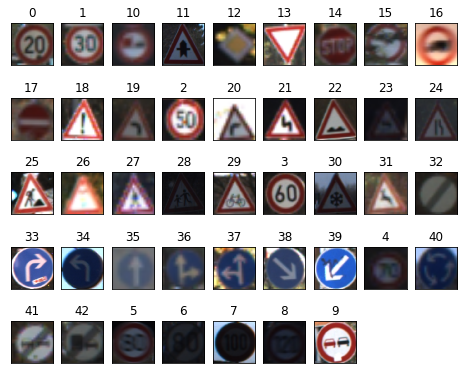

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline 

# Show examples from each class
class_names = np.unique(train_labels)
num_classes = len(class_names)
fig = plt.figure(figsize=(8,8))
for i in range(num_classes):
    ax = fig.add_subplot(6, 9, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    indices = np.where(np.isin(train_labels, class_names[i]))[0]
    plt.imshow(cv2.cvtColor(train_signs[int(np.random.choice(indices, 1))], cv2.COLOR_BGR2RGB))
plt.show()

In [5]:
from sklearn.utils import shuffle
train_files, train_signs, train_bboxes, train_labels = shuffle(train_files, train_signs, train_bboxes, train_labels)
# plt.imshow(cv2.cvtColor(train_images.get(train_files[0])[0], cv2.COLOR_BGR2RGB))
# plt.show()
# plt.imshow(cv2.cvtColor(train_signs[0], cv2.COLOR_BGR2RGB))
# plt.show()
# print(train_bboxes[0])
# print(train_labels[0])

# Data pre-processing
tr_signs = np.array(train_signs)[0:600]
tr_labels = np.array(train_labels)[0:600]
va_signs = np.array(train_signs)[600:852]
va_labels = np.array(train_labels)[600:852]
te_signs = np.array(test_signs)
te_labels = np.array(test_labels)

tr_signs = tr_signs.astype('float32')
va_signs = va_signs.astype('float32')
te_signs = te_signs.astype('float32')
tr_signs /= 255.0
va_signs /= 255.0
te_signs /= 255.0

from keras.utils import np_utils
tr_labels = np_utils.to_categorical(tr_labels, num_classes)
va_labels = np_utils.to_categorical(va_labels, num_classes)
te_labels = np_utils.to_categorical(te_labels, num_classes)

In [6]:
# Tensorboard
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir='logs/prueba/{}'.format(time()))

### Assignment 1: Multi-Layer Perceptron

### Default

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras import optimizers

mlp = Sequential()
mlp.add(Dense(8, input_shape=(SIGN_SIZE[0], SIGN_SIZE[1], 3)))
mlp.add(Flatten())
mlp.add(Activation('relu'))
mlp.add(Dropout(0.3))
mlp.add(Dense(num_classes))
mlp.add(Activation('softmax'))

opt = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
mlp.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 224, 224, 8)       32        
_________________________________________________________________
flatten_7 (Flatten)          (None, 401408)            0         
_________________________________________________________________
activation_16 (Activation)   (None, 401408)            0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 401408)            0         
_________________________________________________________________
dense_17 (Dense)             (None, 43)                17260587  
_________________________________________________________________
activation_17 (Activation)   (None, 43)                0         
Total params: 17,260,619
Trainable params: 17,260,619
Non-trainable params: 0
________________________________________________________________

In [15]:
n_epochs = 30
data = mlp.fit(tr_signs, tr_labels, batch_size=16, epochs=n_epochs, verbose=2, validation_data=(va_signs, va_labels), callbacks=[tensorboard])

start = time()
loss, acc = mlp.evaluate(te_signs, te_labels, verbose=0)
end = time()
print('MLP took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

Train on 600 samples, validate on 252 samples
Epoch 1/30
 - 4s - loss: 4.3203 - acc: 0.1567 - val_loss: 3.2250 - val_acc: 0.1548
Epoch 2/30
 - 4s - loss: 2.8171 - acc: 0.3083 - val_loss: 2.5338 - val_acc: 0.3730
Epoch 3/30
 - 4s - loss: 2.3072 - acc: 0.4133 - val_loss: 2.3260 - val_acc: 0.3849
Epoch 4/30
 - 4s - loss: 2.0540 - acc: 0.4817 - val_loss: 2.1928 - val_acc: 0.3968
Epoch 5/30
 - 4s - loss: 1.8052 - acc: 0.5083 - val_loss: 2.1420 - val_acc: 0.3929
Epoch 6/30
 - 4s - loss: 1.6628 - acc: 0.5667 - val_loss: 2.1234 - val_acc: 0.3968
Epoch 7/30
 - 4s - loss: 1.4888 - acc: 0.5800 - val_loss: 1.9721 - val_acc: 0.5040
Epoch 8/30
 - 4s - loss: 1.3367 - acc: 0.6267 - val_loss: 1.7654 - val_acc: 0.5198
Epoch 9/30
 - 4s - loss: 1.1914 - acc: 0.6617 - val_loss: 1.7846 - val_acc: 0.5238
Epoch 10/30
 - 4s - loss: 1.0699 - acc: 0.7050 - val_loss: 1.8725 - val_acc: 0.4802
Epoch 11/30
 - 4s - loss: 0.9441 - acc: 0.7267 - val_loss: 1.7577 - val_acc: 0.5198
Epoch 12/30
 - 4s - loss: 0.8626 - acc:

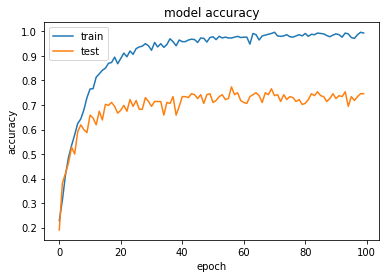

In [36]:
plt.plot(data.history['acc'])
plt.plot(data.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Tune

Updates:
DEFAULT: acc 0.73

1) Apparently the FNN is overfitting. Let's try to change architecture and reduce epochs. 4 neurons Input layer. 30 epochs (0.77 acc)

2) 

In [21]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras import optimizers

mlp1 = Sequential()
mlp1.add(Dense(6, input_shape=(SIGN_SIZE[0], SIGN_SIZE[1], 3)))
mlp1.add(Flatten())
mlp1.add(Activation('relu'))
mlp1.add(Dropout(0.3))
mlp1.add(Dense(num_classes))
mlp1.add(Activation('softmax'))

opt = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
mlp1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
mlp1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 224, 224, 6)       24        
_________________________________________________________________
flatten_10 (Flatten)         (None, 301056)            0         
_________________________________________________________________
activation_22 (Activation)   (None, 301056)            0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 301056)            0         
_________________________________________________________________
dense_23 (Dense)             (None, 43)                12945451  
_________________________________________________________________
activation_23 (Activation)   (None, 43)                0         
Total params: 12,945,475
Trainable params: 12,945,475
Non-trainable params: 0
________________________________________________________________

In [22]:
n_epochs = 30
data1 = mlp1.fit(tr_signs, tr_labels, batch_size=16, epochs=n_epochs, verbose=2, validation_data=(va_signs, va_labels), callbacks=[tensorboard])

start = time()
loss, acc = mlp1.evaluate(te_signs, te_labels, verbose=0)
end = time()
print('MLP took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

Train on 600 samples, validate on 252 samples
Epoch 1/30
 - 3s - loss: 4.1778 - acc: 0.1300 - val_loss: 3.5772 - val_acc: 0.1746
Epoch 2/30
 - 3s - loss: 3.1475 - acc: 0.2583 - val_loss: 2.9601 - val_acc: 0.3016
Epoch 3/30
 - 3s - loss: 2.4353 - acc: 0.4400 - val_loss: 2.7673 - val_acc: 0.4127
Epoch 4/30
 - 3s - loss: 1.9691 - acc: 0.5433 - val_loss: 2.4589 - val_acc: 0.4008
Epoch 5/30
 - 3s - loss: 1.6542 - acc: 0.6150 - val_loss: 2.0196 - val_acc: 0.5437
Epoch 6/30
 - 3s - loss: 1.3281 - acc: 0.6817 - val_loss: 1.9911 - val_acc: 0.5794
Epoch 7/30
 - 3s - loss: 1.2075 - acc: 0.7433 - val_loss: 1.9528 - val_acc: 0.5317
Epoch 8/30
 - 3s - loss: 1.0781 - acc: 0.7483 - val_loss: 1.5961 - val_acc: 0.6746
Epoch 9/30
 - 3s - loss: 0.8489 - acc: 0.8217 - val_loss: 1.8690 - val_acc: 0.6151
Epoch 10/30
 - 3s - loss: 0.9466 - acc: 0.8067 - val_loss: 1.6201 - val_acc: 0.6389
Epoch 11/30
 - 3s - loss: 0.6968 - acc: 0.8483 - val_loss: 2.0172 - val_acc: 0.6111
Epoch 12/30
 - 3s - loss: 0.7514 - acc:

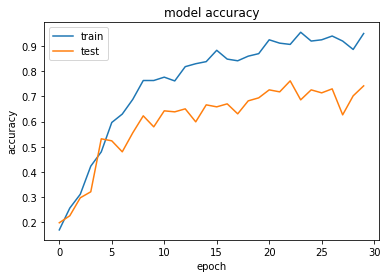

In [18]:
plt.plot(data1.history['acc'])
plt.plot(data1.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()